In [2]:
import matplotlib.pyplot as plt
import numpy as np
import imageryclient as ic
import pandas as pd
from caveclient import CAVEclient
from skimage.measure import find_contours
from skimage.measure import block_reduce
from scipy.stats import mode
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import map_coordinates
from matplotlib.path import Path


In [3]:
client = CAVEclient('minnie65_public')
# client.materialize.get_versions()
client.version = 1412
client.materialize.get_tables()

['bodor_pt_target_proofread',
 'nucleus_functional_area_assignment',
 'proofreading_status_and_strategy',
 'coregistration_auto_phase3_fwd_apl_vess_combined_v2',
 'vortex_thalamic_proofreading_status',
 'multi_input_spine_predictions_ssa',
 'synapse_target_structure',
 'coregistration_auto_phase3_fwd_v2',
 'vortex_astrocyte_proofreading_status',
 'gamlin_2023_mcs_met_types',
 'vortex_manual_myelination_v0',
 'synapse_target_predictions_ssa',
 'aibs_metamodel_celltypes_v661',
 'baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'allen_column_mtypes_v2',
 'bodor_pt_cells',
 'aibs_metamodel_mtypes_v661_v2',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'apl_functional_coreg_vess_fwd',
 'vortex_compartment_targets',
 'baylor_log_reg_cell_type_coarse_v1',
 'functional_properties_v3_bcm',
 'gamlin_2023_mcs',
 'l5et_column',
 'pt_synapse_targets',
 'coregistration_manual_v4',
 'cg_cell_type_calls',
 'synapses_pni_2',
 'nucl

In [7]:
client.materialize.get_table_metadata('vortex_manual_myelination_v0')


{'schema': 'bound_tag_bool_valid',
 'aligned_volume': 'minnie65_phase3',
 'table_name': 'vortex_manual_myelination_v0',
 'id': 65546,
 'created': '2024-06-01T20:26:13.580770',
 'valid': True,
 'schema_type': 'bound_tag_bool_valid',
 'user_id': '4447',
 'description': 'This table annotates the presence (TRUE) or absence of myelin (FALSE) along the axon of a subset of cells. Each point listed was inspected and manually labled. The segmentation associated with this assessment is the valid_id, NOT necessarily the root id. Manual labeling performed as part of VORTEX. Uploaded and maintained by Bethanny Danskin.',
 'notice_text': 'Myelination status assessed for the axon of the VALID_ID, not the pt_root_id.',
 'reference_table': None,
 'flat_segmentation_source': None,
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2024-12-17T23:19:46.833317',
 'segmentation_source': None,
 'pcg_table_name': 'minnie3_v1',
 'last_updated': '2025-07-03T01:00:00.183673',
 'voxe

In [ ]:
myelin_df = client.materialize.query_table('vortex_manual_myelination_v0')
cell_type_df = client.materialize.query_table('aibs_metamodel_celltypes_v661')
# cell_type_df = client.materialize.query_table('baylor_gnn_cell_type_fine_model_v2')
myelin_df.iloc[0:10]



Number of valid myelin entries: 79076


In [340]:
# Total counts per pt_root_id (convert to DataFrame)

counts = myelin_df["pt_root_id"].value_counts().reset_index()
counts.columns = ["pt_root_id", "total_count"]

# counts_df = counts.reset_index()
# counts_df.columns = ["pt_root_id", "total_count"]

# Get counts where tag == "t"
t_counts = myelin_df[myelin_df["tag"] == "t"]["pt_root_id"].value_counts().reset_index()
t_counts.columns = ["pt_root_id", "myelin = true"]

# Merge total and t counts
merged_counts = counts.merge(t_counts, on="pt_root_id", how="left")

# Fill missing t_count values with 0
merged_counts["myelin = true"] = merged_counts["myelin = true"].fillna(0).astype(int)

# First, reduce cell_type_df to the columns we need
cell_type_lookup = cell_type_df[["pt_root_id", "cell_type"]]

merged_counts = merged_counts[merged_counts["pt_root_id"] != 0]

# Merge with the counts table
final_df = merged_counts.merge(cell_type_lookup, on="pt_root_id", how="left")

# Optional: preview
# print(final_df.iloc[0:20])

# print(final_df.tail())

# print(merged_counts.iloc[1:10])

# print(myelin_df.iloc[1:10])

final_df_sorted = final_df.sort_values(by="myelin = true", ascending=False)

print(final_df_sorted.iloc[0:20])

print(final_df_sorted["myelin = true"].iloc[0:20].sum())


             pt_root_id  total_count  myelin = true cell_type
4    864691136578820884         3333           1479     5P-ET
0    864691135441799752        22762            643       23P
2    864691135763975990         4632            244        BC
3    864691135639556411         3778            140     5P-IT
23   864691135564772183           88             88     6P-CT
98   864691135582153156           51             51       NaN
96   864691136362762978           52             43        MC
221  864691135446295026           39             39       NaN
319  864691135582182596           33             33       NaN
325  864691135273080337           33             32       23P
693  864691135465381701           31             30        BC
718  864691135868814358           29             28        BC
749  864691136818636398           28             28       NaN
773  864691135988362499           26             26       NaN
139  864691136021592568           46             25        BC
1    864

In [ ]:

# all entries of a certain root id.
myelin_df[myelin_df["pt_root_id"] == 864691135465381701]

# #find number of entries where valid == "t"
# myelin_true = myelin_df[myelin_df['valid'] == 't']
# num_true = myelin_true.shape[0]
# print(f"Number of valid myelin entries: {num_true}")
# print(myelin_df.size)

,id,created,superceded_id,valid,tag,valid_id,pt_supervoxel_id,pt_root_id,pt_position
25444,61302,2024-12-17 23:18:38.511165+00:00,NaN,t,t,864691135865971164,89175203845901858,864691135465381701,"[177560, 194992, 18528]"
25445,61303,2024-12-17 23:18:38.511780+00:00,NaN,t,t,864691135865971164,89245435084424490,864691135465381701,"[178120, 193816, 18387]"
25446,61304,2024-12-17 23:18:38.512386+00:00,NaN,t,t,864691135865971164,89175203845898071,864691135465381701,"[177560, 194896, 18516]"
25447,61305,2024-12-17 23:18:38.512974+00:00,NaN,t,t,864691135865971164,89245435084433714,864691135465381701,"[178040, 193912, 18397]"
25448,61306,2024-12-17 23:18:38.513587+00:00,NaN,t,t,864691135865971164,89175135126372040,864691135465381701,"[177648, 194608, 18479]"
25449,61307,2024-12-17 23:18:38.514183+00:00,NaN,t,t,864691135865971164,89175135126388984,864691135465381701,"[177624, 194656, 18485]"
25450,61308,2024-12-17 23:18:38.514869+00:00,NaN,t,t,864691135865971164,89245435084455544,864691135465381701,"[177776, 194232, 18432]"
25591,61309,2024-12-17 23:18:38.515543+00:00,NaN,t,t,864691135865971164,89245366364892345,864691135465381701,"[178208, 193664, 18371]"
25592,61310,2024-12-17 23:18:38.516155+00:00,NaN,t,t,864691135865971164,89175203845889030,864691135465381701,"[177560, 194848, 18509]"
25593,61311,2024-12-17 23:18:38.516759+00:00,NaN,t,t,864691135865971164,89245435084460780,864691135465381701,"[177800, 194176, 18426]"


In [303]:
# Filter rows where tag == 't'
myelin_true = myelin_df[myelin_df['tag'] == 't']

# Get the number of unique pt_root_id values
num_unique_ids = myelin_true['pt_root_id'].nunique()

print(f"Number of unique pt_root_id's where tag = 't': {num_unique_ids}")

counts_per_id = myelin_true['pt_root_id'].value_counts()

print(counts_per_id[20:30])

Number of unique pt_root_id's where tag = 't': 85
pt_root_id
864691135411863538    14
864691135429081586     9
864691136967417294     4
864691135849033822     3
864691134988422266     2
864691133550765652     2
864691135807225629     2
864691135801231458     2
864691135384768715     2
864691136843716718     1
Name: count, dtype: int64


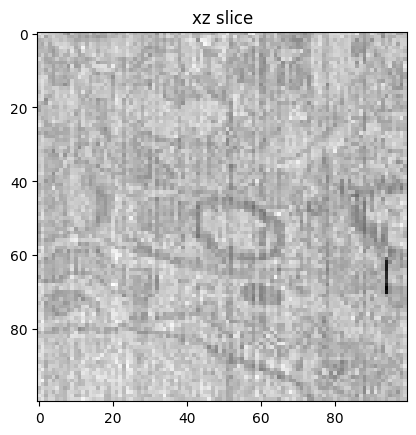

In [7]:
#pull out image and segmentation given a center point, pt_root_id, plane, and box size

img_client = ic.ImageryClient(client=client)

ctr = [196128, 164134, 21225] #original
# ctr = [196128, 164234, 21225]
# ctr = [136058.0,	108980.0,	18497.0]
pt_root_id = 864691135441799752

plane = 'xz'
# box_sz_microns = 2.4 #Pick something divisible by 4.
box_sz_microns = 4


x_size = box_sz_microns * 1000 / 4
y_size = box_sz_microns * 1000 / 4
z_size = box_sz_microns * 1000 / 40

if plane == 'xz':
    y_size = 2
elif plane == 'xy':
    z_size = 2
elif plane == 'yz':
    x_size = 2


bounds = np.array([
    [ctr[0] - x_size // 2, ctr[1] - y_size //2, ctr[2] - z_size // 2],  # Lower bound
    [ctr[0] + x_size // 2, ctr[1] + y_size //2, ctr[2] + z_size // 2]  # Upper bound
])

image, segs = img_client.image_and_segmentation_cutout(
    bounds, 
    image_mip = 0,
    root_ids = pt_root_id,
    split_segmentations=False,
    )

#resamples segmentation and image to 40nm isotropic (segmentation resampled using mode)
if plane == 'xz':
    # segs = segs[::5,:]
    segs = mode(segs[:segs.shape[0]//5*5, :].reshape(-1, 5, segs.shape[1]), axis=1)[0].squeeze()
    image = block_reduce(image, block_size=(5, 1), func=np.mean)
elif plane == 'xy':
    segs = segs[:,:,1]
    # segs = segs[::5,::5]
    segs = mode(segs[:segs.shape[0]//5*5, :segs.shape[1]//5*5]
               .reshape(segs.shape[0]//5, 5, segs.shape[1]//5, 5)
               .swapaxes(1,2).reshape(-1, 25), axis=1)[0].reshape(segs.shape[0]//5, segs.shape[1]//5)
    image = block_reduce(image[:,:,1], block_size=(5, 5), func=np.mean)
elif plane == 'yz':
    # segs = segs[::5,:]
    segs = mode(segs[:segs.shape[0]//5*5, :].reshape(-1, 5, segs.shape[1]), axis=1)[0].squeeze()
    image = block_reduce(image, block_size=(5, 1), func=np.mean)

# Plot
plt.imshow(image, cmap='gray')
plt.title(plane + " slice")
# plt.axis('off')
plt.show()

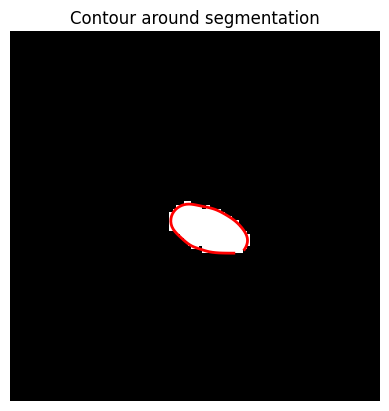

In [8]:
# Get contour of segmentation

sigma = 3

mask = segs > 1
contours = find_contours(mask.astype(float), level=0.5)
#select the contour that contains the center point
contour = next(c for c in contours if Path(c).contains_point((segs.shape[0] // 2, segs.shape[1] // 2)))

smoothed_x = gaussian_filter1d(contour[:, 1], sigma)
smoothed_y = gaussian_filter1d(contour[:, 0], sigma)

contour_sm = np.stack([smoothed_y, smoothed_x], axis=1)

plt.imshow(mask, cmap='gray')
for contour in contours:
    plt.plot(contour_sm[:, 1], contour_sm[:, 0], linewidth=2, color='red')
plt.title("Contour around segmentation")
plt.axis('off')
plt.show()


149.27430005728354


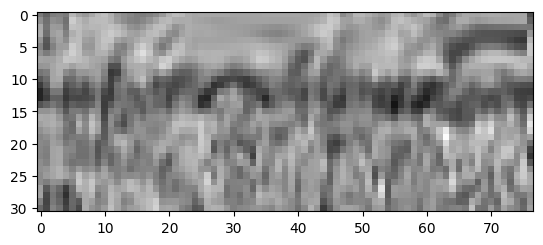

In [10]:
#Do normal based unwrapping to straighten the contour (make it easier on the classifier)

n_in = 10
n_out = 20
step_size = .5  # pixel spacing along normal

# Storage for sampled intensities
sampled_array = np.zeros((n_in + n_out + 1, len(contour_sm)))

# Loop through contour
for i, (y, x) in enumerate(contour_sm):

    # Compute tangent: difference between neighboring points
    prev_pt = contour_sm[i - 1]
    next_pt = contour_sm[(i + 1) % len(contour_sm)]
    tangent = next_pt - prev_pt

    # Normalize tangent
    tangent = tangent / np.linalg.norm(tangent)

    # Normal is perpendicular to tangent: swap and negate
    normal = np.array([-tangent[1], tangent[0]])

    # Sample along normal
    samples = []
    for j in range(-n_in, n_out + 1):
        offset = normal * j * step_size
        sample_y = y + offset[0]
        sample_x = x + offset[1]

        # Use interpolation to get subpixel intensity
        val = map_coordinates(image, [[sample_y], [sample_x]], order=2, mode='reflect')[0]
        samples.append(val)

    sampled_array[:, i] = samples

plt.imshow(sampled_array,cmap='gray',vmin=100, vmax=150)

print(np.max(sampled_array))



In [13]:
print(len(contour_sm))

77


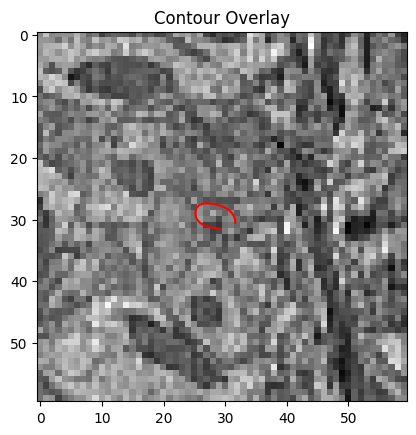

In [282]:
#visualize contour overlayed on image
plt.imshow(image, cmap='gray')
plt.plot(contour_sm[:, 1], contour_sm[:, 0], color='red', linewidth=1.5)
plt.title("Contour Overlay")
# plt.axis('off')
plt.show()

In [ ]:
#Now, given a point (ctr) and a pt_root_id, let's get the direction the axon is traveling.

sk_df = client.skeleton.get_skeleton(pt_root_id, output_format='swc')

,id,type,x,y,z,radius,parent
100,100,2,786.424,662.744,850.40,0.355,99
101,101,2,787.064,663.464,850.80,0.355,100
102,102,2,788.048,665.048,850.08,0.355,101
103,103,2,788.968,665.952,850.00,0.355,102
104,104,2,790.072,667.248,850.00,0.355,103
105,105,2,790.664,668.192,849.72,0.355,104
106,106,2,791.264,669.616,849.84,0.355,105
107,107,2,792.000,671.616,850.56,0.355,106
108,108,2,792.688,672.992,850.88,0.355,107
109,109,2,792.744,673.704,851.04,0.355,108


In [231]:
#convert sk_df from micron coordinates to voxel coordinates.
sk_df_vx = sk_df.copy()
sk_df_vx['x'] = sk_df_vx['x']*1000 // 4
sk_df_vx['y'] = sk_df_vx['y']*1000 // 4
sk_df_vx['z'] = sk_df_vx['z']*1000 // 40

# Compute distances to all points in the skeleton DataFrame
distances = np.sqrt(
    (sk_df_vx['x'] - ctr[0])**2 +
    (sk_df_vx['y'] - ctr[1])**2 +
    (sk_df_vx['z'] - ctr[2])**2
)

#get plane perpendicular to axon
closest_idx = distances.idxmin() #Find index of closest point
parent_idx = sk_df.loc[closest_idx, 'parent'] #Get parent index of that point
vector_diff = sk_df_vx.loc[closest_idx, ['x', 'y', 'z']].values - sk_df_vx.loc[parent_idx, ['x', 'y', 'z']].values
max_dim = np.argmax(np.abs(vector_diff)) #find the dimension with the largest difference
possible_planes = ['yz','xz','xy']
plane = possible_planes[max_dim]
print(plane)




xz


Below this is some scratchpad code.

~~~~~~~~~
  -   -
    O

In [228]:
sk_df_vx.iloc[10400:10440]
# sk_df_vx.head()

,id,type,x,y,z,radius,parent
10400,10400,2,138002.0,109044.0,18637.0,0.121,10399
10401,10401,2,137564.0,109076.0,18621.0,0.121,10400
10402,10402,2,136848.0,109218.0,18574.0,0.121,10401
10403,10403,2,136830.0,109256.0,18574.0,0.121,10402
10404,10404,2,136306.0,109292.0,18530.0,0.121,10403
10405,10405,2,136248.0,109242.0,18519.0,0.121,10404
10406,10406,2,136058.0,108980.0,18497.0,0.121,10405
10407,10407,2,136218.0,108574.0,18482.0,0.121,10406
10408,10408,2,136244.0,108494.0,18483.0,0.121,10407
10409,10409,2,136314.0,108070.0,18483.0,0.121,10408


In [214]:
parent_counts = sk_df['parent'].value_counts()

# Count how many times each parent ID appears
# print(parent_counts[1:20])

# Get parent IDs that have more than one child
multi_child_parents = parent_counts[parent_counts > 1].index

# Find all rows in sk_df where the index matches one of those parents
branch_indices = sk_df[sk_df.index.isin(multi_child_parents)].index

parent_150_rows = sk_df[sk_df['parent'] == 150]
print(parent_150_rows)
# print(branch_indices)

        id  type        x        y      z  radius  parent
151    151     2  814.696  736.304  860.8   0.158     150
1418  1418     2  815.056  737.048  863.2   0.269     150


(60, 60)


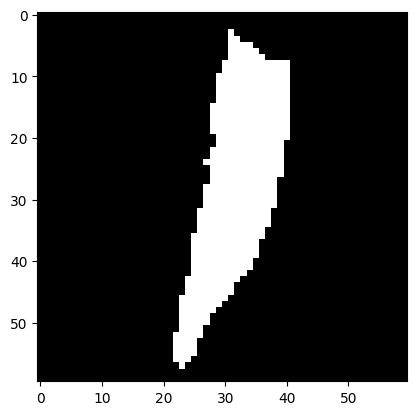

In [122]:
print(segs.shape)

plt.imshow(segs.T, cmap='gray')


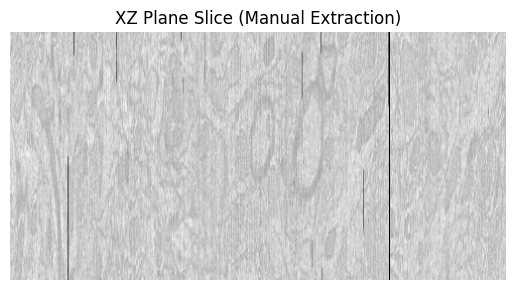

In [43]:
img_client = ic.ImageryClient(client=client)

# Pull a cubic 3D cutout centered on your point
ctr = [196128, 164134, 21225]
size = 500  # Example size in all dimensions

bounds_3d = ic.bounds_from_center(ctr, width=size, height=3, depth=size)

image, segs = img_client.image_and_segmentation_cutout(bounds_3d, split_segmentations=True)

# image has shape (Z, Y, X)

# Get an XZ slice by fixing Y
y_index = image.shape[1] // 2  # middle of Y axis
xz_slice = image[:, y_index, :]

# Plot
import matplotlib.pyplot as plt
plt.imshow(xz_slice[::-1], cmap='gray')
plt.title("XZ Plane Slice (Manual Extraction)")
plt.axis('off')
plt.show()

In [ ]:


# Your center point and pt_root_id
ctr = [218778, 242806, 23811]  # x, y, z
pt_root_id = 864691135441799752  # example

# Define plane and bbox size
plane = 'xz'  # can adjust as needed
bbox_size = (300, 300)  # in (x, z) for XZ plane

# Pull image and segmentation cutout
image, segs = img_client.image_and_segmentation_cutout(
    ctr,
    split_segmentations=True,
    bbox_size=bbox_size,
    scale_to_bounds=True,
)

# Extract segmentation for the pt_root_id
seg_mask = segs == pt_root_id

# Find boundary using scikit-image
contours = find_contours(seg_mask.astype(float), 0.5)

# Plot
plt.imshow(seg_mask, cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.title(f'Boundary of axon {pt_root_id} in {plane.upper()} plane')
plt.axis('off')
plt.show()


In [ ]:
ctr = [196128, 164134, 21225] #original
# ctr = [196128, 164234, 21225]
# ctr = [136058.0,	108980.0,	18497.0]
pt_root_id = 864691135441799752

plane = 'xz'
# box_sz_microns = 2.4 #Pick something divisible by 4.
box_sz_microns = 4


x_size = box_sz_microns * 1000 / 4
y_size = box_sz_microns * 1000 / 4
z_size = box_sz_microns * 1000 / 40

# if plane == 'xz':
#     y_size = 2
# elif plane == 'xy':
#     z_size = 2
# elif plane == 'yz':
#     x_size = 2


bounds = np.array([
    [ctr[0] - x_size // 2, ctr[1] - y_size //2, ctr[2] - z_size // 2],  # Lower bound
    [ctr[0] + x_size // 2, ctr[1] + y_size //2, ctr[2] + z_size // 2]  # Upper bound
])

image, segs = img_client.image_and_segmentation_cutout(
    bounds, 
    image_mip = 0,
    root_ids = pt_root_id,
    split_segmentations=False,
    )